<a href="https://colab.research.google.com/github/nmningmei/BESA_readers/blob/master/HDDM_for_RT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U pip

In [2]:
!pip cache purge

Files removed: 4


In [3]:
!pip install numpy==1.19.3
!pip install -U mkl
!pip install pymc
!pip install kabuki
!pip install hddm==0.8.0

     |████████████████████████████████| 278.6 MB 32 kB/s 
     |████████████████████████████████| 4.1 MB 34.8 MB/s 
  Attempting uninstall: mkl
    Found existing installation: mkl 2019.0
    Uninstalling mkl-2019.0:
      Successfully uninstalled mkl-2019.0
     |████████████████████████████████| 385 kB 5.3 MB/s 
  Created wheel for pymc: filename=pymc-2.3.8-cp37-cp37m-linux_x86_64.whl size=1353046 sha256=058b41c9816de93d5d0c97b6d171c0864ebe853a20129f760dd18fc06c66e8a6
  Stored in directory: /root/.cache/pip/wheels/3b/9b/1d/2a2ddbe80519db2698745f0988ce50c36ad38aac886a4ee0ca
Successfully built pymc
     |████████████████████████████████| 44 kB 1.6 MB/s 
  Created wheel for kabuki: filename=kabuki-0.6.3-py3-none-any.whl size=36545 sha256=02f4091905964c9bf86ee12abf16a1ea9b7fec1c6d802133977c215ad62077d4
  Stored in directory: /root/.cache/pip/wheels/29/cb/6a/02f80c7cde0e973c5ec0f4202aee3ab1b10d84682052d99af5
Successfully built kabuki
     |████████████████████████████████| 601 kB 5.2 MB/s

In [7]:
import hddm

In [40]:
import pandas as pd
import numpy as np

In [9]:
df = pd.read_csv('behavioral stacked dataframe.csv')

In [51]:
df['response.rt_raw'].values

array([0.46018523, 0.63030195, 0.44028515, ..., 0.7003628 , 0.61026728,
       0.61031032])

In [16]:
df_for_fit = df[['response.rt_raw','response.keys_raw','sub','visible.keys_raw']]
df_for_fit.columns = ['rt','response','subject','visibility']
df_for_fit['subj_idx'] = df_for_fit['subject'].apply(lambda x: int(x[-1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
df_for_fit = df_for_fit.dropna(axis = 0)
df_for_fit = df_for_fit[df_for_fit['visibility'] != 99]

In [64]:
res = []
for visibility, df_sub in df_for_fit.groupby(['visibility']):
    # Instantiate model object passing it our data (no need to call flip_errors() before passing it).
    # This will tailor an individual hierarchical DDM around your dataset.
    m = hddm.HDDM(df_sub,
                is_group_model = True,
                bias = True, # include the bias term, so we will have {a,v,t,b} parameters
                )
    # find a good starting point which helps with the convergence.
    m.find_starting_values()
    # start drawing 1000 samples and discarding 5000 as burn-in
    m.sample(2000, burn=100)
    stats = m.gen_stats()
    stats['visibility'] = visibility
    res.append(stats)
res = pd.concat(res)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 184.2 sec

/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 160.2 sec

/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 144.5 sec

In [68]:
res['attribute'] = list(res.index)
res['awareness'] = res['visibility'].map({1:'Unconscious',2:'Glimpse',3:'Conscious'})
res.head()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err,visibility,attribute,awareness
a,4.03368,0.721612,2.64706,3.55426,4.03677,4.5068,5.47371,0.0313272,1,a,Unconscious
a_std,1.95129,0.574739,1.0612,1.52646,1.86694,2.28723,3.30492,0.0276709,1,a_std,Unconscious
a_subj.1,1.91821,0.142522,1.67912,1.81179,1.90692,2.00744,2.22495,0.0122143,1,a_subj.1,Unconscious
a_subj.2,7.31426,0.930973,5.29906,6.76533,7.38991,7.9214,8.9189,0.0910839,1,a_subj.2,Unconscious
a_subj.3,4.48463,0.557318,3.56636,4.04747,4.43183,4.86301,5.56904,0.0534446,1,a_subj.3,Unconscious


In [25]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')

In [79]:
def subj_map():
    temp = {'sub-01':'sub-01',
            'sub-03':'sub-02',
            'sub-04':'sub-03',
            'sub-05':'sub-04',
            'sub-02':'sub-05',
            'sub-06':'sub-06',
            'sub-07':'sub-07',}
    return temp
def chance_map():
    temp = {'sub-01':True,
            'sub-02':True,
            'sub-03':True,
            'sub-04':True,
            'sub-05':False,
            'sub-06':False,
            'sub-07':False,}
    return temp
def row_map():
    return {'v':0,
            'a':0,
            't':1,
            'z':1}
def col_map():
    return {'v':0,
            'a':1,
            't':0,
            'z':1}
res['sub'] = res['attribute'].apply(lambda x: 'sub-0' + x.split('.')[-1])
res['subject'] = res['sub'].map(subj_map())
res['chance'] = res['subject'].map(chance_map())
res['Type'] = res['attribute'].apply(lambda x: x[0])
res['row'] = res['Type'].map(row_map())
res['col'] = res['Type'].map(col_map())
res.head()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err,visibility,attribute,awareness,sub,subject,chance,Type,row,col
a,4.03368,0.721612,2.64706,3.55426,4.03677,4.5068,5.47371,0.0313272,1,a,Unconscious,sub-0a,NaN,NaN,a,0,1
a_std,1.95129,0.574739,1.0612,1.52646,1.86694,2.28723,3.30492,0.0276709,1,a_std,Unconscious,sub-0a_std,NaN,NaN,a,0,1
a_subj.1,1.91821,0.142522,1.67912,1.81179,1.90692,2.00744,2.22495,0.0122143,1,a_subj.1,Unconscious,sub-01,sub-01,True,a,0,1
a_subj.2,7.31426,0.930973,5.29906,6.76533,7.38991,7.9214,8.9189,0.0910839,1,a_subj.2,Unconscious,sub-02,sub-05,False,a,0,1
a_subj.3,4.48463,0.557318,3.56636,4.04747,4.43183,4.86301,5.56904,0.0534446,1,a_subj.3,Unconscious,sub-03,sub-02,True,a,0,1


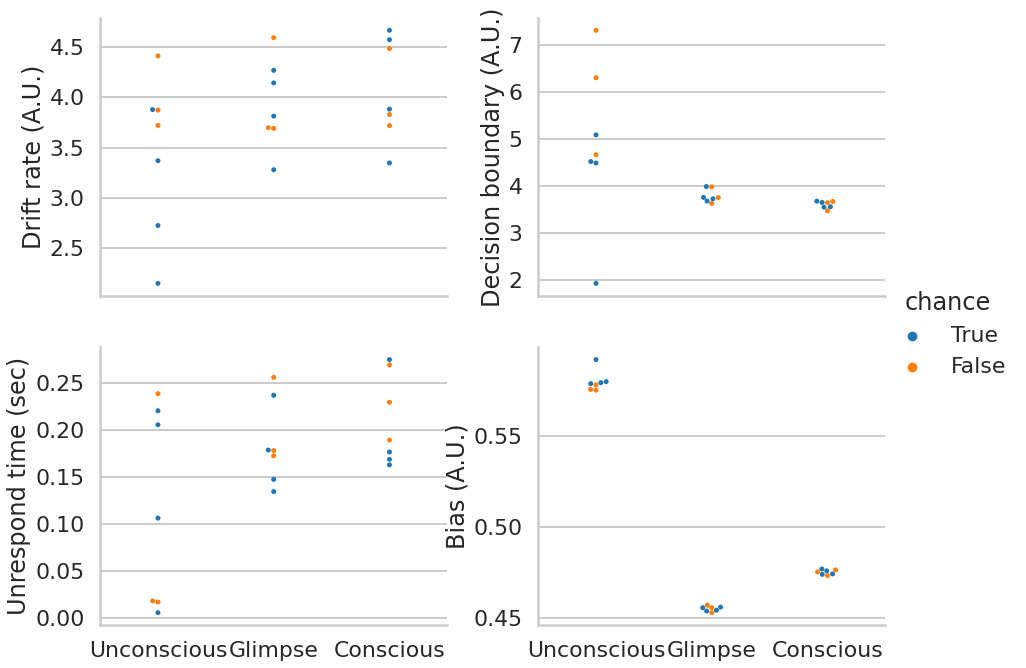

In [91]:
df_plot = res[res['attribute'].apply(lambda x : '_subj' in x)]

g = sns.catplot(x = 'awareness',
                y = 'mean',
                hue = 'chance',
                hue_order = [True,False],
                row = 'row',
                col = 'col',
                data = df_plot,
                kind = 'swarm',
                sharey = False,
                aspect = 1.25,
                )
g.set_axis_labels('','')
for ax,ylabel in zip(g.axes.flatten(),
                    ['Drift rate (A.U.)',
                        'Decision boundary (A.U.)',
                        'Unrespond time (sec)',
                        'Bias (A.U.)']):
    ax.set(ylabel = ylabel,title = '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

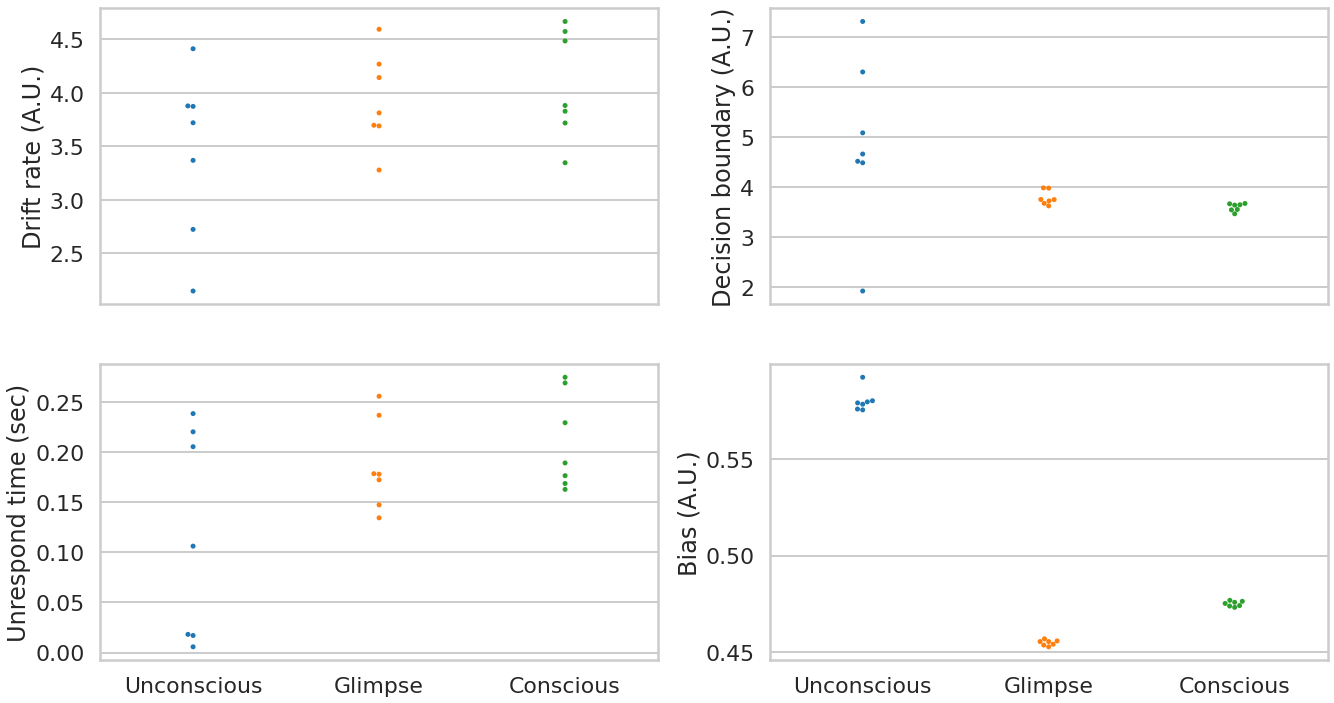

In [71]:
fig,axes = plt.subplots(figsize = (22,12),
                        nrows = 2,
                        ncols = 2,
                        sharex = True,
                        sharey = False,)
for ax,parameter_name,ylabel in zip(axes.flatten(),['v','a','t','z'],
                                    ['Drift rate (A.U.)',
                                     'Decision boundary (A.U.)',
                                     'Unrespond time (sec)',
                                     'Bias (A.U.)']):
    df_sub = res[res['attribute'].apply(lambda x: f'{parameter_name}_subj' in x)]
    df_sub['sub'] = 
    ax = sns.swarmplot(x = 'awareness',y = 'mean',data = df_sub,ax = ax,)
    ax.set(xlabel = '',ylabel = ylabel)


In [62]:
stats.to_csv('HDDM RT results.csv',index = False)